このノートブックでは、Samadhiモデルを使用して「**ノイズ除去オートエンコーダ**」のようなタスクを実行します。

### 🎯 タスクの目的

**ノイズが乗った手書き数字画像（MNIST）を入力**し、Samadhiモデルの「**概念探索（Vitakka）**」と「**状態純化（Vicara）**」のプロセスを経て、**きれいな画像に復元**します。

---

### 🚀 アプローチ: 2段階学習

このデモでは、より高性能なモデルを構築するために2段階の学習プロセスを採用します。

#### 1. Phase 1: 教師なし事前学習 (Autoencoder Pre-training)
* **学習対象**: **Adapter**（入力エンコーダ）と**Decoder**（出力デコーダ）。
* **データ**: **ノイズのないきれいな画像**のみを使用します。
* **目的**: モデルはまず「数字の画像とはどういうものか」という知識を深め、**良質な潜在表現（Latent Space）**を獲得します。

#### 2. Phase 2: 教師ありファインチューニング (Supervised Fine-tuning)
* **初期化**: 事前学習済みのAdapterを使って、各数字（0-9）の**概念（Probe）**を初期化します。
* **学習**: **ノイズ画像を入力**とし、**概念探索と純化プロセス**を通じて**きれいな画像を復元**するタスクを学習させます。

## 🧘 Samadhiモデルの主要コンポーネントと設定

このデモで使用されているSamadhiモデルの主要なコンポーネントとその設定は以下の通りです。これらは `CONFIG_DICT` および `src/presets/vision.py` 内の `create_conv_samadhi` 関数に基づいて構成されています。

---

### Adapter (`CnnAdapter`)

* **役割**: 入力画像（32x32ピクセル、1チャンネル）を潜在空間の表現（次元数64）に変換します。
* **タイプ**: `cnn` (**畳み込みニューラルネットワーク**)
* **主な設定**:
    ```json
    "adapter": {
        "type": "cnn",
        "channels": 1,         # グレースケール画像
        "img_size": 32         # 処理のために28x28を32x32にリサイズ
    }
    ```

---

### Decoder (`CnnDecoder`)

* **役割**: 潜在空間の表現（次元数64）から再構成された画像（32x32ピクセル、1チャンネル）を生成します。
* **タイプ**: `cnn` (**畳み込みニューラルネットワーク**)
* **主な設定**:
    ```json
    "decoder": {
        "type": "cnn",
        "channels": 1,
        "img_size": 32
    }
    ```

---

### Objective (`SupervisedRegressionObjective`)

* **役割**: モデルの学習目標（**損失関数**）を定義します。再構成誤差、安定性、エントロピー、ロードバランスを考慮した損失を計算します。
* **タイプ**: `SupervisedRegressionObjective` クラスを直接使用。
* **主な設定**:
    ```json
    "objective": {
        "stability_coeff": 0.01, # 潜在状態の安定性に対する重み
        "entropy_coeff": 0.05,   # プローブ選択のエントロピーに対する重み
        "balance_coeff": 0.9,    # プローブの利用頻度の均一性に対する重み
    }
    ```

---

### Vitakka (`StandardVitakka`)

* **役割**: 入力された潜在状態から、最も関連性の高い「**概念（Probe）**」を探索し、初期状態 `s0` を生成します。
* **タイプ**: `standard` (SamadhiBuilderのデフォルト)
* **主な設定**:
    ```json
    "vitakka": {
        "n_probes": 10,              # 0-9の数字に対応する10個のプローブ
        "gate_threshold": -1,        # デモ用にゲートは常にオープン
        "mix_alpha": 0.2,            # 入力とプローブの混合比率
        "softmax_temp": 0.2,         # 確率分布のシャープネス調整
        "training_attention_mode": "soft", # 学習時は微分可能なソフトアテンション
        "prediction_attention_mode": "hard", # 推論時はハードアテンション
    }
    ```

---

### Vicara (`StandardVicara`)

* **役割**: Vitakkaで探索された初期状態 `s0` を、指定されたステップ数だけ繰り返し**純化（Refine）**し、最終的な収束状態 `s_final` を導出します。
* **タイプ**: `standard` (SamadhiBuilderのデフォルト)
* **主な設定**:
    ```json
    "vicara": {
        "refine_steps": 5,           # 状態純化の繰り返しステップ数
        "refiner_type": "mlp",       # 内部のRefinerネットワークのタイプ
        "inertia": 0.7               # 状態更新の慣性（前回の状態の影響度）
    }
    ```

---

### Refiners (`MlpRefiner`)

* **役割**: Vicaraの内部で使用されるネットワークで、潜在状態を**再帰的に洗練**させる役割を担います。
* **タイプ**: `mlp` (**多層パーセプトロン**)
* **主な設定**: SamadhiConfigのグローバルな `dim` (**64**) が内部的に伝搬され、Refinerの隠れ層の次元などに影響します。

## 1. ライブラリのインポート

必要なライブラリと、Samadhiフレームワークのコンポーネントを読み込みます。

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from transformers import TrainingArguments
import matplotlib.pyplot as plt

from src.presets.vision import create_conv_samadhi
from src.configs.main import SamadhiConfig
from src.train import SamadhiTrainer
from src.train.objectives.supervised_regression import SupervisedRegressionObjective
from src.train.objectives.autoencoder import AutoencoderObjective

# デバイスの設定
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device: {device}")

/Users/ryota/git_project/mine/samadhi_model/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## 2. モデル設定 (Configuration)

モデルの挙動を定義します。

*   **Img Size 32:** CNNの構造上、28x28のMNIST画像を32x32にリサイズして処理します。
*   **10 Probes:** 0〜9の数字に対応する10個の「概念の受け皿」を用意します。
*   **Refine Steps 5:** 内部で純化ループを5回回して、状態を安定させます。

In [2]:
CONFIG_DICT = {
    "dim": 64,  # Latent Dimension (潜在空間の次元数)
    "seed": 42,
    "labels": [str(i) for i in range(10)],  # ログ用ラベル

    # Adapter (CNN): 画像から潜在特徴を抽出
    "adapter": {
        "type": "cnn",
        "channels": 1,
        "img_size": 32  # 32x32にリサイズ
    },

    # Decoder (CNN): 潜在特徴から画像を再構成
    "decoder": {
        "type": "cnn",
        "channels": 1,
        "img_size": 32
    },

    # Vitakka (探索モジュール): 最適な概念(Probe)を探す
    "vitakka": {
        "n_probes": 10, # 0-9の10個の概念
        "gate_threshold": -1, # デモ用にゲートは常にオープン
        "mix_alpha": 0.2,
        "softmax_temp": 0.2,
        "training_attention_mode": "soft", # 学習時は微分可能にするためSoft Attention
        "prediction_attention_mode": "hard", # 推論時は1つの概念を選ぶHard Attention
    },

    # Vicara (純化モジュール): 状態を繰り返し洗練させる
    "vicara": {
        "refine_steps": 5, # 5回の思考ループ
        "refiner_type": "mlp",
        "inertia": 0.7
    },

    # Objective (学習目標)
    "objective": {
        "stability_coeff": 0.01, # 状態変化を小さくする（安定化）
        "entropy_coeff": 0.05,   # 曖昧さを減らす
        "balance_coeff": 0.9,    # 特定のProbeばかり使われるのを防ぐ
    }
}

## 3. データセットとノイズ注入

MNISTデータセットを読み込み、ガウシアンノイズを加えて「汚れた入力」を作ります。
また、画像を32x32にリサイズする前処理もここで行います。

In [3]:
def mnist_noise_injector(clean_img_tensor):
    """
    画像テンソルにガウシアンノイズを加える関数
    """
    noise = torch.randn_like(clean_img_tensor) * 0.7
    noisy_img = clean_img_tensor + noise
    return noisy_img

class MNISTCleanDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
    def __len__(self):
        return len(self.mnist_dataset)
    def __getitem__(self, idx):
        clean_img, _ = self.mnist_dataset[idx]
        # xもyもきれいな画像
        return {"x": clean_img, "y": clean_img}

class MNISTPairDataset(Dataset):
    """
    (ノイズ画像, きれいな画像) のペアを提供するデータセット
    """

    def __init__(self, mnist_dataset, noise_fn):
        self.mnist_dataset = mnist_dataset
        self.noise_fn = noise_fn

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        clean_img, label = self.mnist_dataset[idx]
        # clean_img は (1, 32, 32) のテンソル
        noisy_img = self.noise_fn(clean_img)

        # Trainerへの返り値
        # x: 入力, y: 目標(正解), class_label: 評価用ラベル
        return {
            "x": noisy_img,
            "y": clean_img,
            "class_label": torch.tensor(label, dtype=torch.long)
        }

## 4. 可視化関数

学習結果を確認するための関数です。

*   **`visualize_inference`**: ノイズ画像、復元画像、正解画像を並べて表示します。
*   **`visualize_probes`**: モデルが学習した「概念（Probe）」自体を画像として可視化します。「0」のProbeは本当に「0」の形をしているでしょうか？

In [4]:
def visualize_inference(trainer, dataloader, num_samples=5):
    """
    推論結果の可視化
    """
    device = trainer.args.device
    model = trainer.model
    model.eval()

    print("\n[Visualization] Running inference...")

    # バッチを取得
    batch = next(iter(dataloader))
    x_noisy = batch["x"][:num_samples].to(device)
    y_clean = batch["y"][:num_samples].to(device)
    labels = batch["class_label"][:num_samples]

    # 推論実行 (Samadhi Step)
    with torch.no_grad():
        output, s_final, meta = model(x_noisy, run_vitakka=True, run_vicara=True)

    # CPUへ移動
    x_noisy = x_noisy.cpu()
    y_clean = y_clean.cpu()
    output = output.cpu()

    # プロット
    fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6))

    rows = ["Input (Noisy)", "Output (Samadhi)", "Ground Truth"]

    for i in range(num_samples):
        # Input
        ax = axes[0, i]
        ax.imshow(x_noisy[i].squeeze(), cmap="gray")
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
        if i == 0: ax.set_ylabel("Input", fontweight='bold')

        # Output
        ax = axes[1, i]
        ax.imshow(output[i].squeeze(), cmap="gray")
        if i == 0: ax.set_ylabel("Reconstruction", fontweight='bold')
        ax.axis("off")

        # GT
        ax = axes[2, i]
        ax.imshow(y_clean[i].squeeze(), cmap="gray")
        if i == 0: ax.set_ylabel("Original", fontweight='bold')
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # 勝者Probeの表示
    if "winner_id" in meta:
        winners = meta["winner_id"]
        print("\n[Probe Winners for these samples]")
        for i in range(num_samples):
            print(f"Sample {i} (True: {labels[i].item()}) -> Winner Probe: {winners[i].item()}")


def visualize_probes(model, decoder, num_probes=10):
    """
    学習された概念(Probe)の可視化
    潜在空間にあるProbeをデコーダーに通して画像化します。
    """
    print("\n[Visualization] Visualizing Probes...")

    probes = model.vitakka.probes.data[:num_probes] # (N, Dim)

    model.eval()
    with torch.no_grad():
        decoded_probes = decoder(probes) # (N, C, H, W)

    decoded_probes = decoded_probes.cpu()

    fig, axes = plt.subplots(1, num_probes, figsize=(num_probes * 1.5, 2))
    for i in range(num_probes):
        if i >= len(decoded_probes): break
        ax = axes[i]
        ax.imshow(decoded_probes[i].squeeze(), cmap="gray")
        ax.set_title(f"Probe {i}")
        ax.axis("off")

    plt.suptitle("Learned Concept Probes (Latent Attractors)")
    plt.tight_layout()
    plt.show()

## 5. 実行フェーズ

ここでは、Samadhiモデルの準備と、2段階学習プロセスの各フェーズを実行します。

---

### フェーズ1: モデルの作成と事前学習 (Unsupervised Pre-training)

まず、Samadhiモデルのインスタンスを作成し、**Adapter**と**Decoder**を対象とした**教師なし事前学習**を行います。これにより、モデルはノイズのないデータから画像の基本的な特徴を学習し、より良い**潜在空間**を構築します。

---

### フェーズ2: プローブの初期化 (Probe Initialization)

事前学習によって「温められた」**Adapter**を使用し、MNISTの**各数字（0-9）に対応する代表的な画像**を潜在空間にマッピングして**プローブ**を初期化します。これにより、**Vitakka**モジュールは学習の初期段階から意味のある**概念**に基づいて探索を開始できます。

---

### フェーズ3: 教師ありファインチューニング (Supervised Fine-tuning)

最後に、**ノイズ付きのMNISTデータセット**を用いて、Samadhiモデル全体の**教師ありファインチューニング**を行います。ここでは、**Vitakka**と**Vicara**が連携し、ノイズ除去と概念の純化を通じて、画像をきれいに再構成する能力を向上させます。

Creating ConvSamadhi Model...
Loading MNIST Data...

--- Phase 1: Unsupervised Pre-training (Autoencoder) ---
Training Adapter & Decoder to learn clean image reconstruction first.


/Users/ryota/git_project/mine/samadhi_model/.venv/lib/python3.14/site-packages/transformers/training_args.py:2301: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
/Users/ryota/git_project/mine/samadhi_model/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.044900


Pre-training completed. Adapter and Decoder are now warmed up.

--- Phase 2: Probe Initialization ---
Initializing probes using the pre-trained Adapter...
Probes initialized with high-quality latent features.

[Visualization] Visualizing Probes...


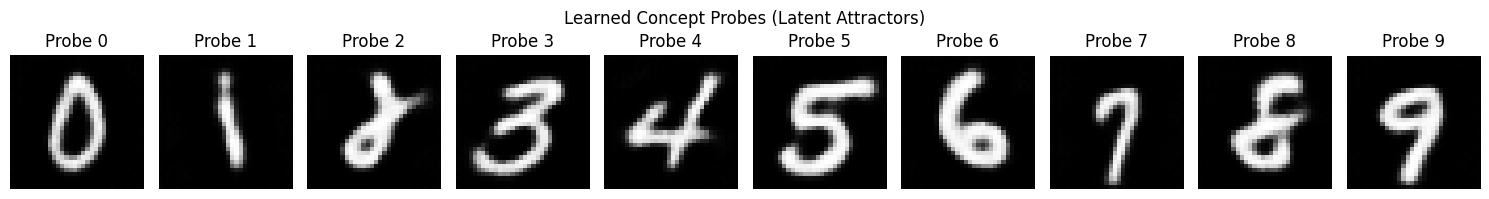

In [5]:
# 1. Config
config = SamadhiConfig.from_dict(CONFIG_DICT)

# 2. Model Creation
print("Creating ConvSamadhi Model...")
model = create_conv_samadhi(config)
model.to(device)

# 3. Data Preparation
print("Loading MNIST Data...")
transform = transforms.Compose([
    transforms.Resize((32, 32)), # 32x32にリサイズ
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset_raw = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_dataset_raw = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_dataset = MNISTPairDataset(train_dataset_raw, mnist_noise_injector)
test_dataset = MNISTPairDataset(test_dataset_raw, mnist_noise_injector)

pretrain_dataset = MNISTCleanDataset(train_dataset_raw)

# ---------------------------------------------------------
# Phase 1: Unsupervised Pre-training (Autoencoder)
# ---------------------------------------------------------
print("\n--- Phase 1: Unsupervised Pre-training (Autoencoder) ---")
print("Training Adapter & Decoder to learn clean image reconstruction first.")

# Pre-training用のObjective (Vitakka/Vicaraをスキップする設定になっている)
ae_objective = AutoencoderObjective(config, device=device)

# Pre-training Arguments (短めでOK)
pretrain_args = TrainingArguments(
    num_train_epochs=1, # 1エポックで十分な場合が多い
    per_device_train_batch_size=64,
    logging_steps=500,
    remove_unused_columns=False,
    label_names=["y"],
    use_mps_device=(device == "mps"),
)

pretrainer = SamadhiTrainer(
    model=model,
    args=pretrain_args,
    objective=ae_objective,
    train_dataset=pretrain_dataset,
    optimizers=(optim.Adam(model.parameters(), lr=0.001), None)
)

pretrainer.train()
print("Pre-training completed. Adapter and Decoder are now warmed up.")


# ---------------------------------------------------------
# Phase 2: Probe Initialization (Latent Space)
# ---------------------------------------------------------
print("\n--- Phase 2: Probe Initialization ---")
print("Initializing probes using the pre-trained Adapter...")
representative_images = [None] * config.vitakka.n_probes
found_labels = [False] * config.vitakka.n_probes

# Iterate to find one image per digit
temp_loader = DataLoader(train_dataset_raw, batch_size=1, shuffle=True)
for img, label in temp_loader:
    lbl = label.item()
    if lbl < config.vitakka.n_probes and not found_labels[lbl]:
        representative_images[lbl] = img
        found_labels[lbl] = True
    if all(found_labels):
        break

# Stack images: (N, C, H, W)
rep_batch = torch.cat(representative_images, dim=0).to(device)

# Pass through Adapter to get Latent Vectors
model.eval()
with torch.no_grad():
    latent_probes = model.adapter(rep_batch) # (N, Dim)

# Assign to Probes
model.vitakka.probes.data = latent_probes
print("Probes initialized with high-quality latent features.")

# 初期状態のProbeを表示してみる
visualize_probes(model, model.decoder)

## 6. 学習開始 (Training)

Trainerを設定して学習を開始します。デモ用なのでEpoch数は少なめ（2回）に設定しています。

In [6]:
# 4. Trainer Setup
# Define Objective
objective = SupervisedRegressionObjective(config, device=device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_args = TrainingArguments(
    num_train_epochs=2, # デモ用に短く設定
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    logging_steps=500,
    remove_unused_columns=False, # カスタムデータセットのために必須
    label_names=["y"], # yをターゲットとして認識させる
    use_mps_device=(device == "mps"),
    report_to="none"
)

trainer = SamadhiTrainer(
    model=model,
    args=training_args,
    objective=objective,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, None)
)

# 5. Training
print("\nStarting Training...")
trainer.train()

/Users/ryota/git_project/mine/samadhi_model/.venv/lib/python3.14/site-packages/transformers/training_args.py:2301: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(
/Users/ryota/git_project/mine/samadhi_model/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Starting Training...


Step,Training Loss
500,0.109300
1000,0.062900
1500,0.051200


/Users/ryota/git_project/mine/samadhi_model/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1876, training_loss=0.06833586153953569, metrics={'train_runtime': 80.0201, 'train_samples_per_second': 1499.623, 'train_steps_per_second': 23.444, 'total_flos': 0.0, 'train_loss': 0.06833586153953569, 'epoch': 2.0})

## 7. 結果確認

学習後のモデルで推論を行い、どれくらいきれいにノイズが除去されたかを確認します。
また、学習によって洗練された「概念Probe」も可視化します。


[Visualization] Running inference...


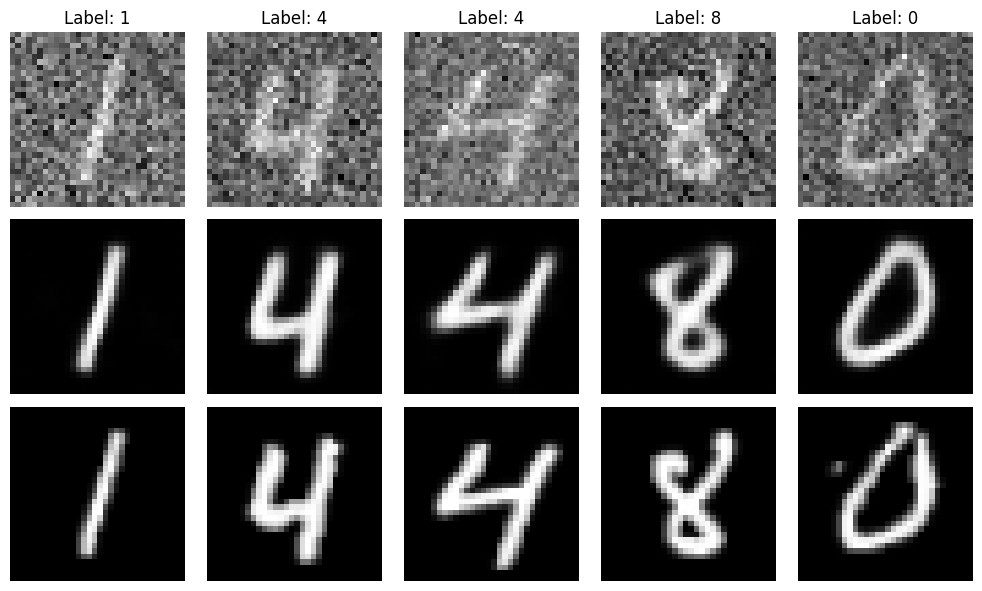


[Probe Winners for these samples]
Sample 0 (True: 1) -> Winner Probe: 1
Sample 1 (True: 4) -> Winner Probe: 4
Sample 2 (True: 4) -> Winner Probe: 4
Sample 3 (True: 8) -> Winner Probe: 2
Sample 4 (True: 0) -> Winner Probe: 3

[Visualization] Visualizing Probes...


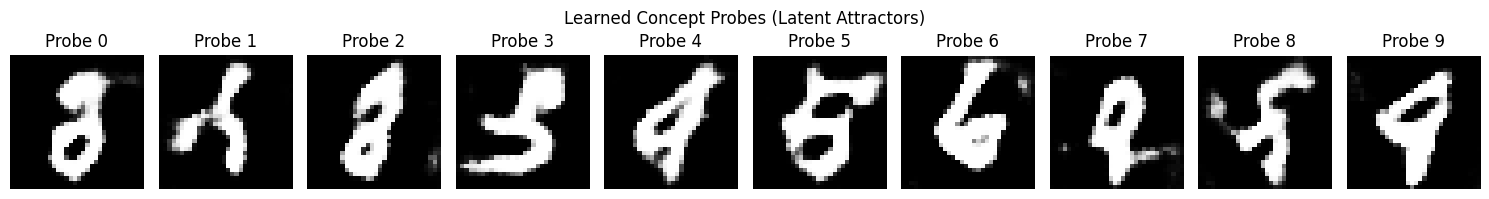

In [7]:
# 6. Evaluation / Visualization
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
visualize_inference(trainer, test_loader)
visualize_probes(model, model.decoder)